# $\mathrm{CH_3CHO}$

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

predict_logσ_wΔ

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "CH3CHO" 
nice_name = "CH₃CHO"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

([202.0, 206.0, 210.0, 214.0, 218.0, 222.0, 226.0, 230.0, 234.0, 238.0  …  1140.0, 1169.0, 1276.0, 1290.0, 1317.0, 1406.0, 1491.0, 1550.0, 1592.0, 1672.0], [5.6e-22, 5.3e-22, 4.9e-22, 4.8e-22, 5.2e-22, 6.5e-22, 9.6e-22, 1.51e-21, 2.41e-21, 3.75e-21  …  4.957e-20, 5.083e-20, 5.449e-20, 5.476e-20, 5.552e-20, 5.827e-20, 6.005e-20, 6.122e-20, 6.045e-20, 6.089e-20], [298.0, 298.0, 294.0, 294.0, 298.0, 298.0, 298.0, 298.0, 298.0, 300.0, 298.0, 298.0, 298.0, 298.0, 294.0, 243.0, 293.0, 500.0, 574.0], [NaN, 300.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 1700.0, 1672.0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  19, 19, 19, 19, 19, 19, 19, 19, 19, 19], "K", "Organics (carbonyls)", "CH3CHO", "nm", "cm^2")

In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

4275


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,249.802,144.3,254.0,362.0,0,Float64
2,σ,4.46705e-18,2.211e-25,3.123e-20,1.14e-16,0,Float64
3,T,295.863,293.0,294.0,300.0,0,Float64
4,source_id,11.1726,1,13.0,17,0,Int64


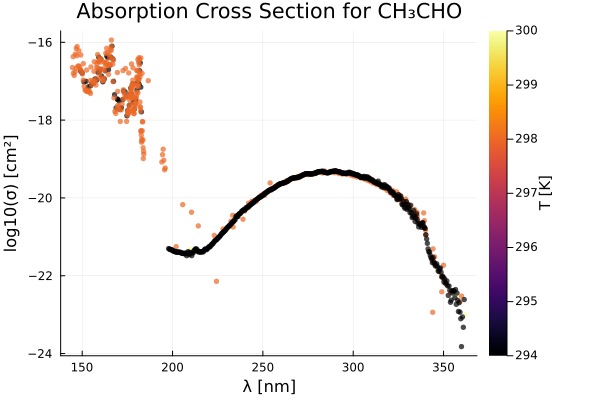

In [8]:
nskip = 5

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)


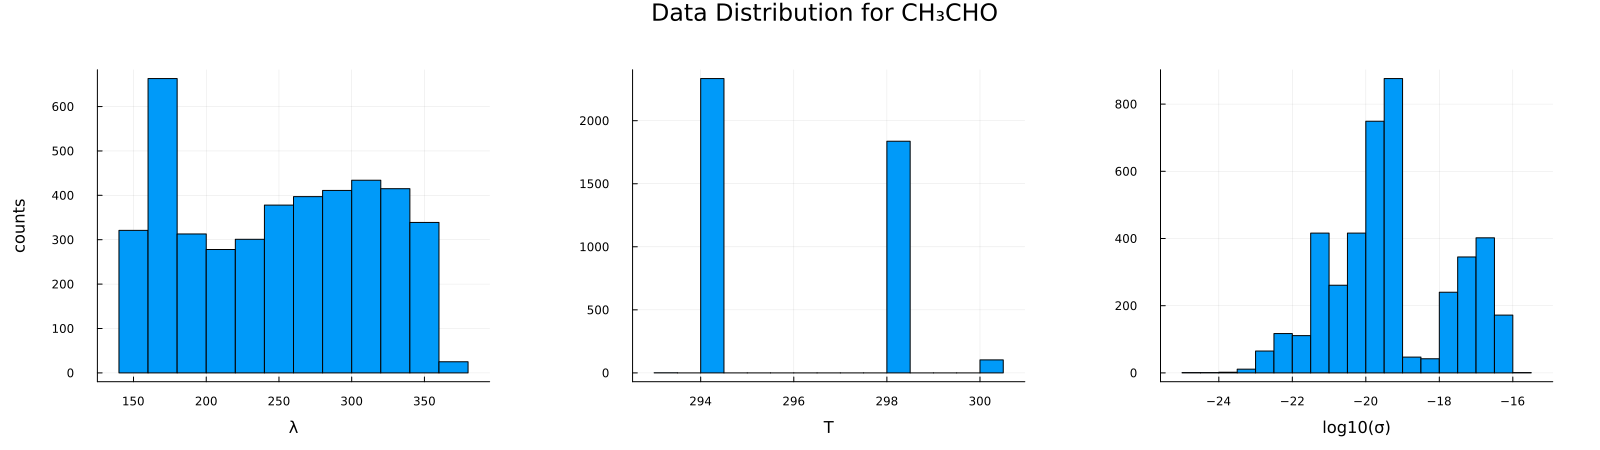

In [9]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [10]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [11]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [12]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,308.0,3.24e-20,293.0
2,148.77,2.35e-17,294.0
3,148.99,2.06e-17,294.0
4,149.09,1.83e-17,294.0
5,149.16,1.65e-17,294.0
6,149.26,1.53e-17,294.0
7,149.52,1.64e-17,294.0
8,149.8,1.74e-17,294.0
9,149.98,1.63e-17,294.0


In [13]:
function representative_rand_sample(column::AbstractVector, nbins::Int, npoints::Int)
    n_per_bin = floor(Int, npoints/nbins)
    hist = fit(Histogram, column, nbins=nbins)
    bin_edges = hist.edges[1]
    
    idx_out = []
    
    # loop over each bin
    for i ∈ 1:size(bin_edges, 1)-1
        bin_idxs = findall(ξ -> bin_edges[i] < ξ && ξ < bin_edges[i+1], column)
        n_to_sample = minimum([n_per_bin, size(bin_idxs, 1)])
        idx_res = sample(bin_idxs, n_to_sample, replace=false)
        push!(idx_out, idx_res)  # sample without replacement
    end

    return unique(vcat(idx_out...))
end

λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 



idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))


df_sampled = df_unique[idxs_res, :]


max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

144.3

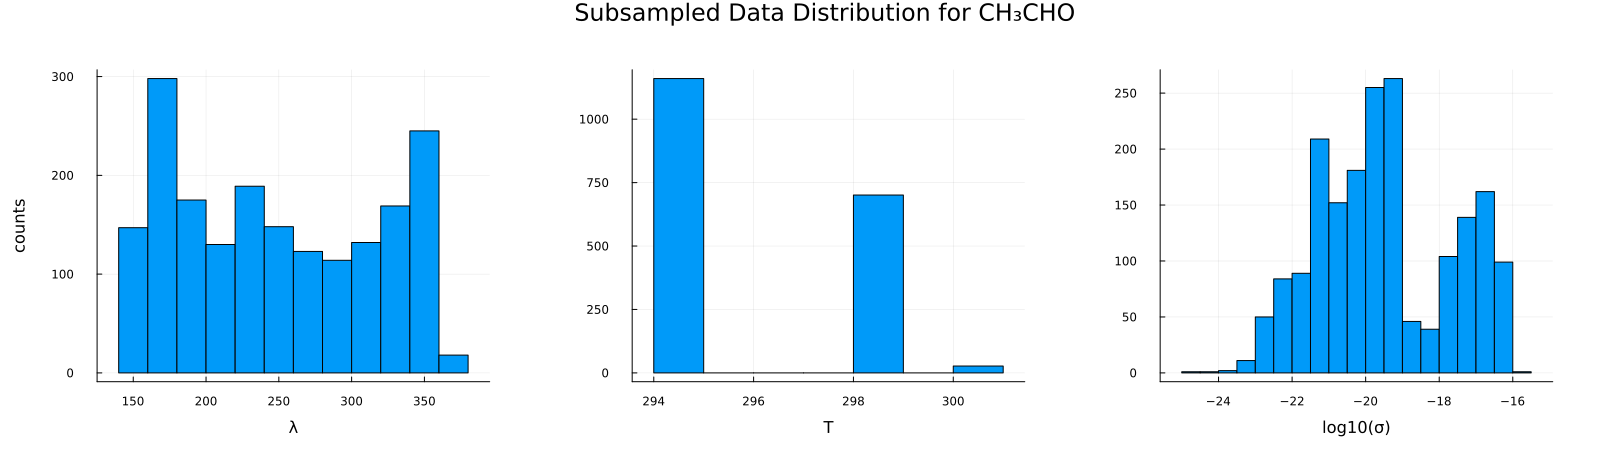

In [14]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

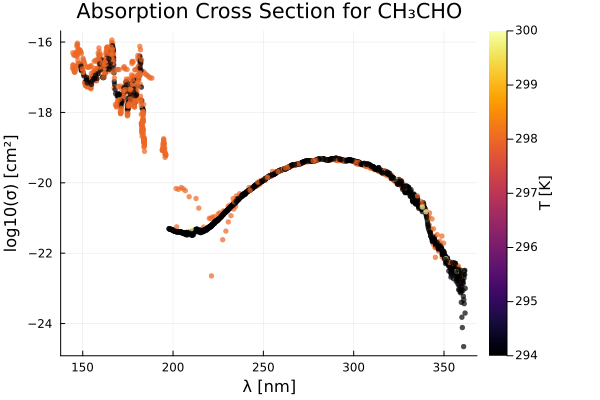

In [15]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [29]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

1793


In [30]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

95-element Vector{Float64}:
 -22.038816290187565
 -20.64016451766011
 -20.447331783887808
 -17.713813083058962
 -20.340654364253822
 -19.950781977329818
 -19.470441326978836
 -21.96537154337468
 -19.525346746637936
 -16.962621316927976
 -20.761953896871205
 -21.101274818410506
 -18.79464133188689
   ⋮
 -17.210709854702447
 -17.79313366363411
 -19.353008462522876
 -17.627087997029893
 -20.200797343699474
 -21.55736347421777
 -22.388382889445666
 -19.374378918575093
 -19.85078088734462
 -19.316052869248487
 -20.279757981712944
 -20.98296666070122

In [31]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [32]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(1.1976715708196408, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.221436123214979, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(0.692361945557905, exp, 1.4901161193847656e-8)), 
  σ² = 0.13249581094700347, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [33]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0     1.229298e+03     1.525464e+03
 * time: 0.00014901161193847656
     1     9.348601e+02     5.491321e+02
 * time: 8.519935846328735
     2     5.423479e+02     2.243677e+02
 * time: 9.963989019393921
     3     4.656280e+02     9.313453e+01
 * time: 10.897876977920532
     4     2.676018e+02     2.261670e+02
 * time: 12.979576826095581
     5     1.898426e+02     2.432775e+02
 * time: 14.794611930847168
     6     1.477676e+02     6.756091e+01
 * time: 15.810575008392334
     7     1.389821e+02     9.005150e+01
 * time: 16.909245014190674
     8     1.032247e+02     2.191945e+02
 * time: 18.48241400718689
     9     7.038996e+01     1.094132e+02
 * time: 20.12128782272339
    10     6.235331e+01     1.803287e+01
 * time: 21.184892892837524
    11     6.192692e+01     1.465800e+01
 * time: 22.80053997039795
    12     6.170374e+01     7.451396e+00
 * time: 24.42554783821106
    13     6.168768e+01     6.211515e-02
 * time: 26.04669690132

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @796 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @277 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [34]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [3.878872780406875, 0.9635958912030709, 4.855325169557208, -3.35076851677869],
 minimum = 61.687672902298914,
 iterations = 1000,
 converged = false,)

In [35]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


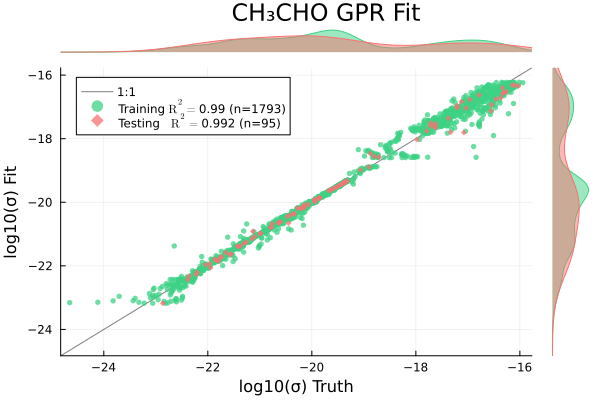

In [36]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


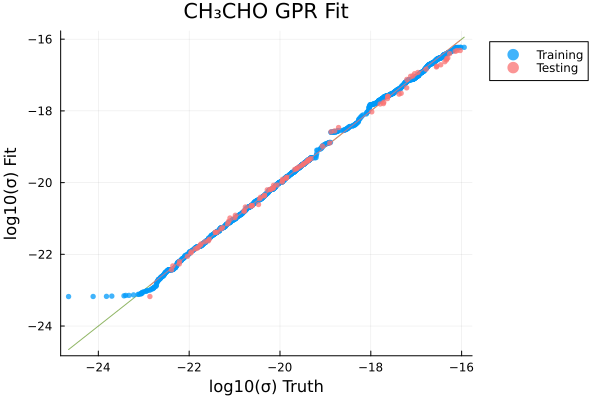

In [37]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


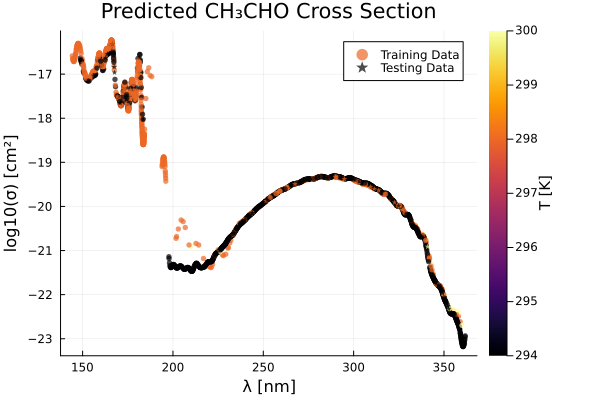

In [38]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

194.249
361.76


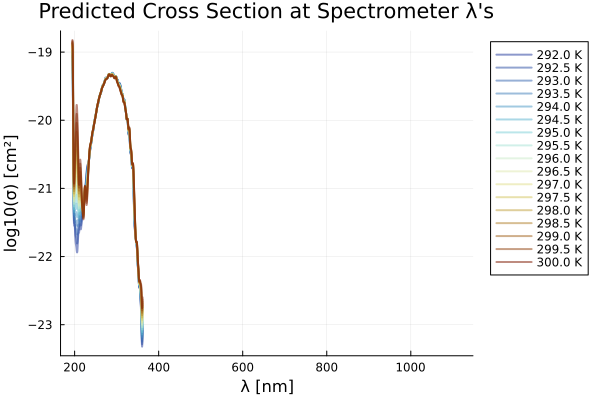

In [39]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

function predict_logσ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = predict_mean(mach, Xout)
    
    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    res[idxs] .= NaN 
    return res
end



p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

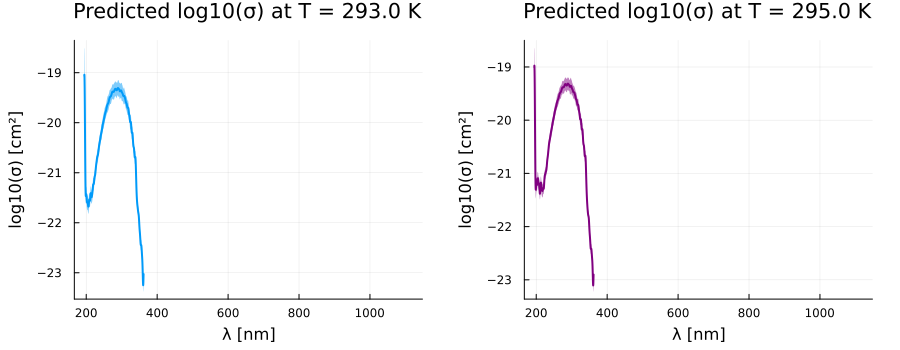

In [40]:
function predict_logσ_wΔ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = MLJ.predict(mach, Xout)

    logσ = mean.(res)
    Δlogσ = std.(res)

    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    logσ[idxs] .= NaN 
    Δlogσ[idxs] .= NaN 
    return logσ, Δlogσ
    #return res
end

Tplot = 293.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 295.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 